# In which events do you think that there is a risk of missing a medal in Paris based on the boats that have qualified already?

1.  answer the performance question posed in a format that is suitable for comprehension by a non-data specialist
2. explain the process you went through to tackle the performance question including the key decisions you had to make and the limitations of your chosen approach
3. outline the key questions you would ask British Rowing coaches and the Performance Leadership Team to further inform your modelling approach

## Process
1. Import data from excel
    * [x] Import data
    * [ ] Transform data to have the following structure

Original structure:

| Olympiad  | Year | Round | Round_Number | Position | Country | Time | Medalled |
|-----------|------|-------|--------------|----------|---------|------|----------|

Processed structure:

| Olympiad  | Year | Country | Avg_Time_off_winner | Medalled |
|-----------|------|---------|---------------------|----------|

Final structure:

| Olympiad  | Country | Year_1 | Avg_Time_of_winner_Year_1 | Year_2 | Avg_Time_of_winner_Year_2 | Medalled_at_Olym | Avg_Time_of_winner_Olym |
|-----------|---------|--------|---------------------------|--------|---------------------------|------------------|-------------------------|
    
2. Create Naive Bayes classifier to predict chance of winning medal


In [173]:
# Import data

import pandas as pd
import numpy as np

def medalled(row):
    if row['Round'] == 'Final' and row['Round_Number'] == 'A' and row['Position'] <= 3:
        val = 1
    else:
        val = 0
    return val


def adjust_b_final_position(row):
    if row['Round'] == 'Final' and row['Round_Number'] == 'B':
        val = row['Position'] + 6
    else:
        val = row['Position']
    return val


def get_winning_times(df):
    df1 = df.query('(Round == "Final" and Round_Number == "A") | (Round != "Final")')
    winning_time_df = df1.groupby(['Boat_Class', 'Year', 'Round'])['Time'].min()

    return winning_time_df


def add_winning_times(df, winning_time_df):
    df2 = df.merge(winning_time_df, left_on=['Boat_Class', 'Year', 'Round'], right_on=['Boat_Class', 'Year', 'Round'], how='inner')
    df2.rename(columns={'Time_x':'Time', 'Time_y':'Winning_Time'}, inplace=True)

    return df2


def calculate_time_diff(row):
    if (row['Round'] == 'Final' and row['Round_Number'] == 'A') or row['Round'] != 'Final':
        val = row['Winning_Time_Seconds'] / row['Time_Seconds']
    else:
        val = np.NaN

    return val


def add_time_diff(df):
    df['Time_Seconds'] = (pd.to_timedelta(df['Time'].astype(str))).dt.total_seconds()
    df['Winning_Time_Seconds'] = (pd.to_timedelta(df['Winning_Time'].astype(str))).dt.total_seconds()

    df['Time_diff'] = df.apply(calculate_time_diff, axis=1)

    df.drop(['Time_Seconds', 'Winning_Time_Seconds'], axis=1, inplace=True)

    return df


def get_position_df(df):
    position_df = df.query('Round == "Final"').groupby(['Boat_Class', 'Year', 'Country']).agg({'Position': ['max'], 'Medalled': ['max']})
    position_df.columns = position_df.columns.get_level_values(0)

    return position_df


def get_time_diff_df(df):
    agg = {'Time_diff': ['mean']}
    time_df = df.groupby(['Boat_Class', 'Year', 'Country']).agg(agg)
    time_df.columns = time_df.columns.get_level_values(0)

    return time_df


def create_positions_df(time_df, position_df):
    results_df = time_df.merge(position_df, left_on=['Boat_Class', 'Year', 'Country'], right_on=['Boat_Class', 'Year', 'Country'], how='inner')
    results_df = results_df.reset_index()

    return results_df


def convert_to_results(df):

    time_df = get_time_diff_df(df)
    position_df = get_position_df(df)

    results_df = create_positions_df(time_df, position_df)

    return results_df


def import_results(excel_file: pd.ExcelFile, sheet_name: str) -> pd.DataFrame:

    df = excel_file.parse(sheet_name)
    df = df[df["Year"] >= 2010]

    df['Medalled'] = df.apply(medalled, axis=1)
    df['Position'] = df.apply(adjust_b_final_position, axis=1)
    winning_time_df = get_winning_times(df)

    df = add_winning_times(df, winning_time_df)
    df = add_time_diff(df)

    results_df = convert_to_results(df)

    return df, results_df


def get_all_results():
    xls = pd.ExcelFile("C:\\Users\\simon\\OneDrive\\Documents\\Jobs\\UK Sport Application\\RowingResults.xlsx")

    df_W8, results_W8 = import_results(xls, "W8+")
    df_W4, results_W4 = import_results(xls, "W4-")
    df_W2, results_W2 = import_results(xls, "W2-")
    df_W4x, results_W4x = import_results(xls, "W4x")
    df_LW2x, results_LW2x = import_results(xls, "LW2x")
    df_M8, results_M8 = import_results(xls, "M8+")
    df_M4, results_M4 = import_results(xls, "M4-")
    df_M2, results_M2 = import_results(xls, "M2-")
    df_M4x, results_M4x = import_results(xls, "M4x")

    df = pd.concat([df_W8, df_W4, df_W2, df_W4x, df_LW2x, df_M8, df_M4, df_M2, df_M4x])
    results_df = pd.concat([results_W8, results_W4, results_W2, results_W4x, results_LW2x, results_M8, results_M4, results_M2, results_M4x])

    return df, results_df

df, results_df = get_all_results()


In [200]:
# Show raw race results

year = 2010
boat_class = 'LW2x'

df[(df["Year"] == year) & (df["Boat_Class"] == boat_class)] \
  .sort_values(by=['Boat_Class','Year'], ascending=True) \
  .style \
  .format(precision=3, thousands="", decimal=".") \
  .relabel_index(["Boat Class", "Year", "Round", "Round Number", "Position", "Country", "Time", "Medalled", "Winning Time", "% fastest time"], axis=1) \
  .hide()

Boat Class,Year,Round,Round Number,Position,Country,Time,Medalled,Winning Time,% fastest time
LW2x,2010,Final,A,1,CAN,00:08:06.200000,1,00:08:06.200000,1.000
LW2x,2010,Final,A,2,GER,00:08:07.330000,1,00:08:06.200000,0.998
LW2x,2010,Final,A,3,GRE,00:08:09.140000,1,00:08:06.200000,0.994
LW2x,2010,Final,A,4,AUS,00:08:11.170000,0,00:08:06.200000,0.990
LW2x,2010,Final,A,5,GBR,00:08:13.900000,0,00:08:06.200000,0.984
LW2x,2010,Final,A,6,NZL,00:08:15.690000,0,00:08:06.200000,0.981
LW2x,2010,Final,B,7,CHN,00:07:40.460000,0,00:08:06.200000,nan
LW2x,2010,Final,B,8,USA,00:07:40.830000,0,00:08:06.200000,nan
LW2x,2010,Final,B,9,ITA,00:07:42.860000,0,00:08:06.200000,nan
LW2x,2010,Final,B,10,BEL,00:07:46,0,00:08:06.200000,nan


In [201]:
# Show formatted position results

year = 2010
boat_class = 'LW2x'

results_df[(results_df["Year"] == year) & (results_df["Boat_Class"] == boat_class)] \
  .sort_values(by=['Boat_Class','Year','Position'], ascending=True) \
  .style \
  .format(precision=3, thousands="", decimal=".") \
  .relabel_index(["Boat Class", "Year", "Country", "% fastest time", "Position", "Medalled"], axis=1) \
  .hide()


Boat Class,Year,Country,% fastest time,Position,Medalled
LW2x,2010,CAN,0.993,1,1
LW2x,2010,GER,0.988,2,1
LW2x,2010,GRE,0.996,3,1
LW2x,2010,AUS,0.985,4,0
LW2x,2010,GBR,0.992,5,0
LW2x,2010,NZL,0.988,6,0
LW2x,2010,CHN,0.976,7,0
LW2x,2010,USA,0.989,8,0
LW2x,2010,ITA,0.968,9,0
LW2x,2010,BEL,0.968,10,0


In [202]:
# get results by olympiad

def get_olympiad_df(df: pd.DataFrame, year_1: int, year_2: int, olym_year: int):
    df_1 = df[df["Year"]==year_1]
    df_2 = df[df["Year"]==year_2]
    df_olym = df[df["Year"]==olym_year]
    results_df = df_1.merge(df_2, left_on=['Boat_Class','Country'], right_on=['Boat_Class','Country'], how='outer').merge(df_olym, left_on=['Boat_Class','Country'], right_on=['Boat_Class','Country'], how='outer')

    results_df.rename(columns={'Year_x':'Year_1', 
                               'Time_diff_x':'Time_diff_1',
                               'Position_x':'Position_1',
                               'Medalled_x':'Medalled_1',
                               'Year_y':'Year_2',
                               'Time_diff_y':'Time_diff_2',
                               'Position_y':'Position_2',
                               'Medalled_y':'Medalled_2',
                               'Year':'Year_Olym',
                               'Time_diff':'Time_diff_Olym'}, inplace=True)
    
    results_df = results_df.dropna(subset=['Time_diff_1', 'Time_diff_2'])

    return results_df

def get_all_olympiads_df(df: pd.DataFrame):

    oly_2012 = get_olympiad_df(df, 2010, 2011, 2012)
    oly_2016 = get_olympiad_df(df, 2014, 2015, 2016)
    oly_2020 = get_olympiad_df(df, 2018, 2019, 2020)

    results_df = pd.concat([oly_2012, oly_2016, oly_2020])
    results_df = results_df[results_df['Time_diff_Olym'].notna()]

    results_df = results_df.astype({"Year_1": int, 
                                "Position_1": int,
                                "Medalled_1": int,
                                "Year_2": int,
                                "Position_2": int,
                                "Medalled_2": int,
                                "Position": int,
                                "Medalled": int,
                                "Year_Olym": int,
                                })

    return results_df

olympiad_results_df = get_all_olympiads_df(results_df)


In [204]:
# Show olympiad results

year = 2016
boat_class = 'W8'

olympiad_results_df[(olympiad_results_df["Year_Olym"] == year) & (olympiad_results_df["Boat_Class"] == boat_class)] \
  .style \
  .format(precision=3, thousands="", decimal=".") \
  .hide()

Boat_Class,Year_1,Country,Time_diff_1,Position_1,Medalled_1,Year_2,Time_diff_2,Position_2,Medalled_2,Year_Olym,Time_diff_Olym,Position,Medalled
W8,2014,CAN,0.996,2,1,2015,0.991,3,1,2016,0.988,5,0
W8,2014,GBR,0.975,6,0,2015,0.988,4,0,2016,0.993,2,1
W8,2014,NED,0.969,8,0,2015,0.988,6,0,2016,0.981,6,0
W8,2014,ROU,0.980,4,0,2015,0.976,7,0,2016,0.993,3,1
W8,2014,USA,1.000,1,1,2015,1.000,1,1,2016,1.000,1,1


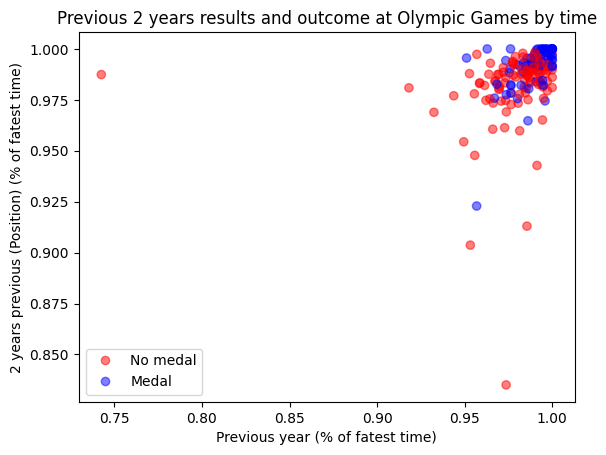

In [207]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scatter plot to show time differences

colors = ListedColormap(['r','b'])
scatter = plt.scatter(olympiad_results_df["Time_diff_1"], 
                      olympiad_results_df["Time_diff_2"], 
                      c=olympiad_results_df["Medalled"], 
                      alpha=0.5, 
                      cmap=colors,
                      marker="o")

plt.xlabel("Previous year (% of fatest time)")
plt.ylabel("2 years previous (Position) (% of fatest time)")
plt.title("Previous 2 years results and outcome at Olympic Games by time")
plt.legend(handles=scatter.legend_elements()[0], labels=['No medal', 'Medal'])

plt.show()


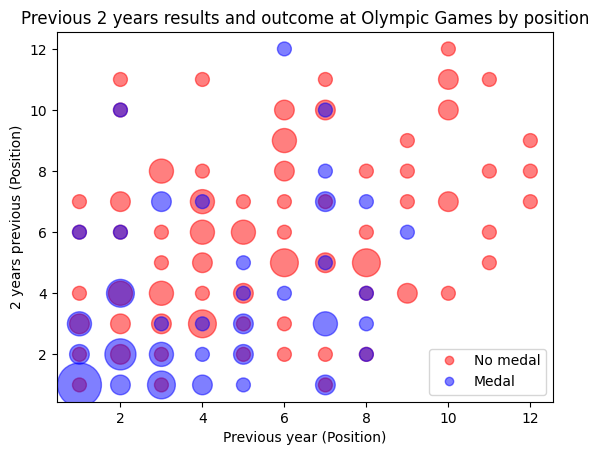

In [208]:
# Scatter plot to show positions

scatter_df = olympiad_results_df.groupby(['Position_1','Position_2','Medalled'])['Position_1'].count().reset_index(name="count")

colors = ListedColormap(['r','b'])
scatter = plt.scatter(scatter_df["Position_1"], 
                      scatter_df["Position_2"], 
                      c=scatter_df["Medalled"], 
                      s=scatter_df["count"]*100,
                      alpha=0.5, 
                      cmap=colors,
                      marker="o")

plt.xlabel("Previous year (Position)")
plt.ylabel("2 years previous (Position)")
plt.title("Previous 2 years results and outcome at Olympic Games by position")
leg1 = plt.legend(handles=scatter.legend_elements()[0], labels=['No medal', 'Medal'])
plt.show()

In [182]:
# Get arrays for training model

X_train = olympiad_results_df[['Position_1', 'Position_2']]
y_train = olympiad_results_df['Medalled']

print(X_train.iloc[[6]])

    Position_1  Position_2
11           9           4


In [183]:
# train model

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight={0:0.7, 1:0.3})
#model = GaussianNB()

model.fit(X_train, y_train)

predicted = model.predict(X_train.iloc[[6]])

print(f"Actual value: {y_train.iloc[[6]]}")
print(f"Predicted value: {predicted[0]}")

Actual value: 11    0
Name: Medalled, dtype: int32
Predicted value: 0


In [184]:
# Get metrics for model

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

y_pred = model.predict(X_train)
accuracy = accuracy_score(y_pred, y_train)
f1 = f1_score(y_pred, y_train, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.7052023121387283
F1 Score: 0.7520802896525439


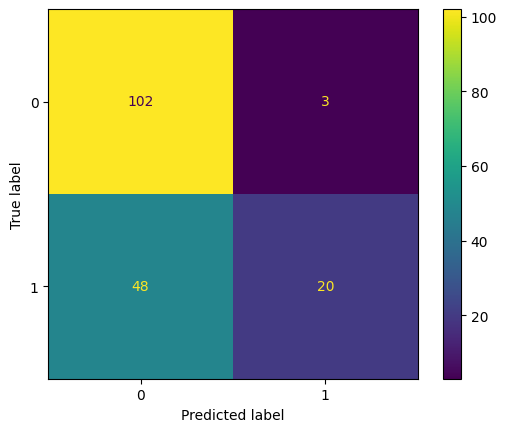

In [185]:
# Display confusion matrix

labels = [0,1]
cm = confusion_matrix(y_train, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [198]:
# Predict probabilities for latest cycle by Country

def get_probabilities_for_latest_cycle_by_country(results_df: pd.DataFrame, country: str, model) -> pd.DataFrame:
    
    oly_2024 = get_olympiad_df(results_df, 2022, 2023, 2024)
    gb_2024 = oly_2024[oly_2024['Country'].str.contains(country)].reset_index(drop=True)

    X_test = gb_2024[['Position_1', 'Position_2']]
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=['No_Medal', 'Medal'])

    df_col_merged = pd.concat([gb_2024, y_pred_prob_df], axis=1)

    return df_col_merged[["Boat_Class","Country","Medal","No_Medal"]]


country = "GBR"
latest_probabilites_by_country_df = get_probabilities_for_latest_cycle_by_country(results_df, country, model)

latest_probabilites_by_country_df \
  .style \
  .format({'Medal': '{:,.2%}'.format, 'No_Medal': '{:,.2%}'.format}) \
  .relabel_index(["Boat Class", "Country", "Medal", "No medal"], axis=1) \
  .hide()

Boat Class,Country,Medal,No medal
W4,GBR,41.68%,58.32%
W2,GBR,4.65%,95.35%
W4x,GBR,53.98%,46.02%
LW2x,GBR,59.85%,40.15%
M8,GBR,59.85%,40.15%
M4,GBR,59.85%,40.15%
M2,GBR,44.81%,55.19%
M4x,GBR,30.51%,69.49%


In [199]:
# Predict probabilities for latest cycle by event

def get_probabilities_for_latest_cycle_by_event(results_df: pd.DataFrame, event: str, model) -> pd.DataFrame:

    oly_2024 = get_olympiad_df(results_df, 2022, 2023, 2024)
    w2_2024 = oly_2024[oly_2024['Boat_Class'].str.startswith(event)].reset_index(drop=True)

    X_test = w2_2024[['Position_1', 'Position_2']]
    y_pred_prob = model.predict_proba(X_test)
    y_pred_prob_df = pd.DataFrame(y_pred_prob, columns=['No_Medal', 'Medal'])

    df_col_merged = pd.concat([w2_2024, y_pred_prob_df], axis=1)

    return df_col_merged[["Boat_Class","Country","Medal","No_Medal"]].sort_values(by=['Medal'], ascending=False)


event = "W2"
latest_probabilites_by_event_df = get_probabilities_for_latest_cycle_by_event(results_df, event, model)

latest_probabilites_by_event_df \
  .style \
  .format({'Medal': '{:,.2%}'.format, 'No_Medal': '{:,.2%}'.format}) \
  .relabel_index(["Boat Class", "Country", "Medal", "No medal"], axis=1) \
  .hide()

Boat Class,Country,Medal,No medal
W2,NED,56.94%,43.06%
W2,ROU,33.28%,66.72%
W2,AUS,28.33%,71.67%
W2,IRL,17.61%,82.39%
W2,USA,15.73%,84.27%
W2,GBR,4.65%,95.35%
W2,ESP,3.72%,96.28%
W2,CZE,1.81%,98.19%
W2,ITA,0.69%,99.31%
